In [24]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

class LoadData:
    def __init__(self, file_path):
        self.file_path = file_path

    def load_data(self):
        data = pd.read_csv(self.file_path)
        return data

    def prepare_data(self, data):
        # Convertir la columna "Ronda" en variables dummy
        data = pd.get_dummies(data, columns=['Ronda'], drop_first=True)

        # Suponiendo que tu DataFrame se llama 'dataframe'
        data['MarcanAmbos'] = (data['GolesLocal'] > 0) & (data['GolesVisitante'] > 0)
        data['MarcanAmbos'] = data['MarcanAmbos'].astype(int)

        # Eliminar columnas irrelevantes
        data = data.drop(['idPartido', 'Temporada', 'Evento', 'GolesLocal', 'GolesVisitante'], axis=1)

        # Separar características y etiquetas
        X = data.drop(['VictoriaLocal', 'Empate', 'VictoriaVisitante', 'MarcanAmbos'], axis=1)
        y = data['MarcanAmbos']

        # Escalar características
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)

        # Dividir los datos en conjuntos de entrenamiento y prueba
        X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)
        
        # Convertir los datos a tensores
        X_train = tf.convert_to_tensor(X_train, dtype=tf.float32)
        X_test = tf.convert_to_tensor(X_test, dtype=tf.float32)
        y_train = tf.convert_to_tensor(y_train.values, dtype=tf.float32)
        y_test = tf.convert_to_tensor(y_test.values, dtype=tf.float32)
        
        return X_train, X_test, y_train, y_test, scaler, X, y
    
# Cargar los datos
data_loader = LoadData('dataframe/champions.csv')
data = data_loader.load_data()
X_train, X_test, y_train, y_test, scaler, X, y = data_loader.prepare_data(data)

In [49]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, Reshape
from tensorflow.keras.optimizers import Adam

class Model:
    def __init__(self, configurations):
        self.configurations = configurations
        self.best_model = None
        self.best_config = None
        self.best_accuracy = 0

    def train_model(self, X_train, y_train):
        for config in self.configurations:
            model = Sequential([
                Reshape((X_train.shape[1], 1), input_shape=(X_train.shape[1],)),
                Conv1D(config['filters'], config['kernel_size'], activation='relu'),
                MaxPooling1D(),
                Flatten(),
                Dense(config['units'], activation='relu'),
                Dropout(config['dropout']),
                Dense(1, activation='sigmoid')
            ])

            optimizer = Adam(learning_rate=config['learning_rate'])
            model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

            history = model.fit(X_train, y_train, epochs=config['epochs'], batch_size=config['batch_size'], validation_split=0.1)
            self.history = history.history  # Almacenar el historial de entrenamiento
            
            
            _, accuracy = model.evaluate(X_test, y_test)
            
            if accuracy > self.best_accuracy:
                self.best_accuracy = accuracy
                self.best_model = model
                self.best_config = config

        return self.history
    
    def get_best_model(self):
        return self.best_model
    
    def get_best_config(self):
        return self.best_config
    

# Definir diferentes configuraciones de red y hiperparámetros
configurations = [
    {'units': 128, 'filters': 64, 'kernel_size': 3, 'learning_rate': 0.01, 'batch_size': 64, 'epochs': 15, 'dropout': 0.1},
    {'units': 256, 'filters': 128, 'kernel_size': 5, 'learning_rate': 0.0001, 'batch_size': 16, 'epochs': 10, 'dropout': 0.3},
    {'units': 64, 'filters': 32, 'kernel_size': 3, 'learning_rate': 0.001, 'batch_size': 32, 'epochs': 10, 'dropout': 0.2}, 
    {'units': 128, 'filters': 64, 'kernel_size': 3, 'learning_rate': 0.01, 'batch_size': 64, 'epochs': 15, 'dropout': 0.1},
    {'units': 256, 'filters': 128, 'kernel_size': 5, 'learning_rate': 0.0001, 'batch_size': 16, 'epochs': 10, 'dropout': 0.3},
    {'units': 64, 'filters': 32, 'kernel_size': 3, 'learning_rate': 0.001, 'batch_size': 32, 'epochs': 10, 'dropout': 0.2},
    {'units': 128, 'filters': 64, 'kernel_size': 3, 'learning_rate': 0.01, 'batch_size': 64, 'epochs': 15, 'dropout': 0.1},
    {'units': 256, 'filters': 128, 'kernel_size': 5, 'learning_rate': 0.0001, 'batch_size': 16, 'epochs': 10, 'dropout': 0.3},
    {'units': 256, 'filters': 128, 'kernel_size': 5, 'learning_rate': 0.0001, 'batch_size': 32, 'epochs': 10, 'dropout': 0.3},
    {'units': 64, 'filters': 32, 'kernel_size': 3, 'learning_rate': 0.001, 'batch_size': 32, 'epochs': 10, 'dropout': 0.2},
    {'units': 128, 'filters': 64, 'kernel_size': 3, 'learning_rate': 0.01, 'batch_size': 64, 'epochs': 15, 'dropout': 0.1},
    {'units': 256, 'filters': 128, 'kernel_size': 5, 'learning_rate': 0.0001, 'batch_size': 16, 'epochs': 10, 'dropout': 0.3},
    {'units': 64, 'filters': 32, 'kernel_size': 3, 'learning_rate': 0.001, 'batch_size': 32, 'epochs': 10, 'dropout': 0.2}
]



model_trainer = Model(configurations)
model_trainer.train_model(X_train, y_train)

model = model_trainer.get_best_model()
best_config = model_trainer.get_best_config()
print("Mejor configuración:", best_config)


Epoch 1/15


/Users/carlotasanchezgonzalez/anaconda3/lib/python3.11/site-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5262 - loss: 0.7292 - val_accuracy: 0.4629 - val_loss: 0.7039
Epoch 2/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5132 - loss: 0.6933 - val_accuracy: 0.5657 - val_loss: 0.6830
Epoch 3/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5370 - loss: 0.6893 - val_accuracy: 0.5257 - val_loss: 0.6863
Epoch 4/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5514 - loss: 0.6822 - val_accuracy: 0.4914 - val_loss: 0.7002
Epoch 5/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5490 - loss: 0.6864 - val_accuracy: 0.5200 - val_loss: 0.6925
Epoch 6/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5530 - loss: 0.6820 - val_accuracy: 0.6057 - val_loss: 0.6679
Epoch 7/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5721 - loss: 0.6791 - val_accuracy: 0.5657 - val_loss: 0.6706
Epoch 8/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5473 - loss: 0.6779 - val_accuracy: 0.5086 - val_loss: 0.6988
Epo

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 508us/step - accuracy: 0.5509 - loss: 0.6910
Loss: 0.6945850253105164
Accuracy: 0.5420560836791992
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Confusion Matrix:
[[172 215]
 [128 234]]


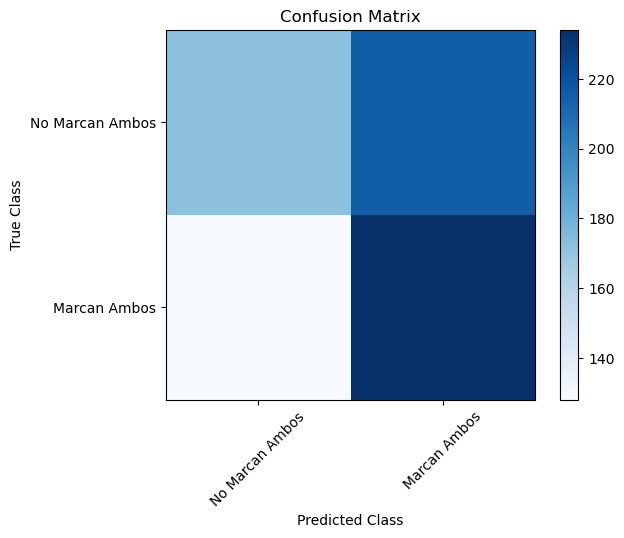

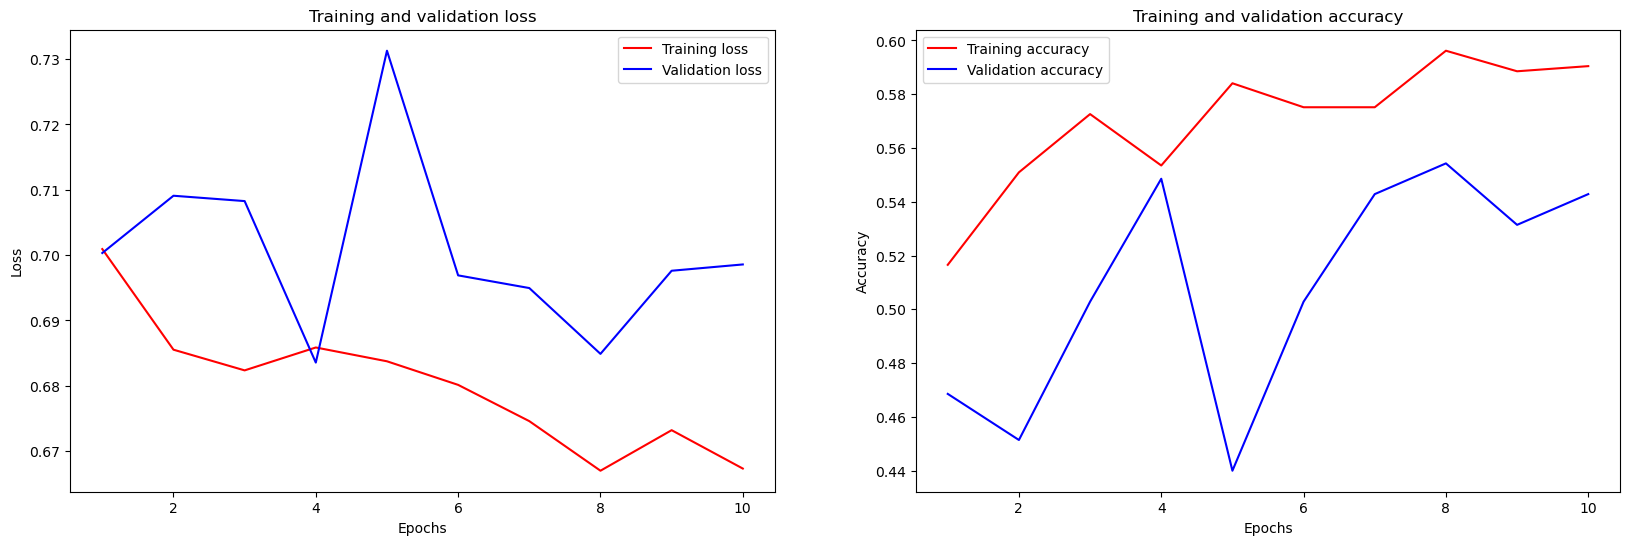

In [50]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import confusion_matrix

class ModelEvaluation:
    def __init__(self, model):
        self.model = model
    
    def evaluate_model(self, X_test, y_test):
        # Evaluar el modelo
        loss, accuracy = self.model.evaluate(X_test, y_test)
        print("Loss:", loss)
        print("Accuracy:", accuracy)

        # Generar predicciones
        class_probabilities = self.model.predict(X_test)
        predictions = np.round(class_probabilities).flatten()
        true_labels = y_test.numpy().flatten()

        # Calcular y mostrar la matriz de confusión
        conf_matrix = confusion_matrix(true_labels, predictions)
        print("Confusion Matrix:")
        print(conf_matrix)

        self.plot_matriz_confusion(conf_matrix)

    def plot_matriz_confusion(self, conf_matrix):
        # Visualizar la matriz de confusión
        plt.imshow(conf_matrix, interpolation="nearest", cmap=plt.cm.Blues)
        plt.colorbar()
        tick_marks = np.arange(2)
        plt.xticks(tick_marks, ['No Marcan Ambos', 'Marcan Ambos'], rotation=45)
        plt.yticks(tick_marks, ['No Marcan Ambos', 'Marcan Ambos'])
        plt.xlabel("Predicted Class")
        plt.ylabel("True Class")
        plt.title("Confusion Matrix")
        plt.show()

    @staticmethod
    def plot_learning_curve_tf(history):
        train_loss = history['loss']
        val_loss = history['val_loss']
        train_accuracy = history['accuracy']
        val_accuracy = history['val_accuracy']
        
        epochs = range(1, len(train_loss) + 1)
        
        plt.figure(figsize=(20, 6))
        
        plt.subplot(1, 2, 1)
        plt.plot(epochs, train_loss, 'r', label='Training loss')
        plt.plot(epochs, val_loss, 'b', label='Validation loss')
        plt.title('Training and validation loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        
        plt.subplot(1, 2, 2)
        plt.plot(epochs, train_accuracy, 'r', label='Training accuracy')
        plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
        plt.title('Training and validation accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()
        
        plt.show()

# Asumiendo que ya tienes el modelo entrenado (model) y los datos de prueba (X_test, y_test)
model_evaluator = ModelEvaluation(model)
model_evaluator.evaluate_model(X_test, y_test)

ModelEvaluation.plot_learning_curve_tf(model_trainer.history)

In [51]:
# Guardar el modelo
tf.keras.models.save_model(model, 'modelos/dnn_ambos_marcan.keras')
model = tf.keras.models.load_model("modelos/dnn_ambos_marcan.keras")

In [52]:
import pandas as pd

# Cargar los datos
df = pd.read_csv("dataframe/champions_23_24.csv")
df = pd.concat([df, data], ignore_index=True)

# Suponiendo que tu DataFrame se llama df
df = df.sort_values(by=['Temporada', 'Ronda'], ascending=[True, True])
df = pd.get_dummies(df, columns=['Ronda'], drop_first=True)

df

,idPartido,Temporada,Local,Visitante,Evento,GolesLocal,GolesVisitante,VictoriaLocal,Empate,VictoriaVisitante,...,%_2_P_Temporada_L,2_Media_G,2_Media_G_Local,2_Media_Goles_PP,2_ValorJugadores,2_MediaJugadores,Ronda_Group stage,Ronda_Quarter-finals,Ronda_Round of 16,Ronda_Semi-finals
2617,2618,2003-01-01,27,12,Arena AufSchalke (Neutral Site),0,3,0,0,1,...,16.67,0.50,0.67,1.42,765.322916,34.787405,False,False,False,False
2493,2494,2003-01-01,38,190,Jan Breydelstadion,1,1,0,1,0,...,25.00,0.29,0.25,1.14,491.567176,23.407961,True,False,False,False
2494,2495,2003-01-01,76,11,Stadion Letná,0,1,0,0,1,...,16.67,0.45,0.17,1.36,694.733672,33.082556,True,False,False,False
2495,2496,2003-01-01,36,12,Stadion FK Partizan,1,1,0,1,0,...,16.67,0.58,0.67,1.58,765.322916,34.787405,True,False,False,False
2496,2497,2003-01-01,49,151,Ibrox Stadium,2,1,1,0,0,...,25.00,0.57,0.75,1.14,512.353693,24.397795,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111,112,2023-01-01,24,7,Stadium Metropolitano,2,1,0,0,1,...,0.00,0.57,0.75,1.29,540.296221,24.558919,False,False,True,False
120,121,2023-01-01,3,1,Allianz Arena,0,0,0,1,0,...,0.00,0.73,0.50,2.00,685.750766,31.170489,False,False,False,True
121,122,2023-01-01,14,28,Signal Iduna Park,0,0,0,1,0,...,16.67,0.45,0.50,1.73,698.621042,33.267669,False,False,False,True
122,123,2023-01-01,28,14,Parc des Princes,0,0,0,1,0,...,0.00,0.45,0.50,1.36,642.492339,27.934450,False,False,False,True


In [56]:
def datos_usuario(df, equipo_local, equipo_visitante):
    # Filtrar el DataFrame para obtener la última fila donde el equipo local y visitante coincidan con los ingresados por el usuario
    filtro_ultimo_partido = ((df['Local'] == equipo_local) & (df['Visitante'] == equipo_visitante)) | ((df['Local'] == equipo_visitante) & (df['Visitante'] == equipo_local))

    # Obtener el último partido entre los equipos ingresados por el usuario
    ultimo_partido_entre_equipos = df[filtro_ultimo_partido].iloc[-1]

    # Obtener los valores para las columnas %_Victorias_Local, %_Empate, %_Victoria_Visitante
    valores_prediccion = ultimo_partido_entre_equipos[['%_Victorias_Local', '%_Empate', '%_Victoria_Visitante', 'Ronda_Group stage', 'Ronda_Quarter-finals',	'Ronda_Round of 16', 'Ronda_Semi-finals']]

    if ultimo_partido_entre_equipos['Local'] == equipo_local and ultimo_partido_entre_equipos['Visitante'] == equipo_visitante:
        porcentajes_de_los_dos = ultimo_partido_entre_equipos[['%_Equipo1_Ganado', '%_Equipo2_Ganado']]

    elif ultimo_partido_entre_equipos['Local'] == equipo_visitante and ultimo_partido_entre_equipos['Visitante'] == equipo_local:
        porcentajes_de_los_dos = ultimo_partido_entre_equipos[['%_Equipo1_Ganado', '%_Equipo2_Ganado']]
        porcentajes_de_los_dos = porcentajes_de_los_dos.rename({'%_Equipo1_Ganado': '%_Equipo2_Ganado', '%_Equipo2_Ganado': '%_Equipo1_Ganado'})


    # 3. Filtrar el DataFrame para obtener las estadísticas del equipo local
    filtro_local = (df['Local'] == equipo_local) | (df['Visitante'] == equipo_local)
    ultima_aparicion_local = df[filtro_local].iloc[-1]
    if ultima_aparicion_local['Local'] == equipo_local:
        estadisticas_equipo_local = ultima_aparicion_local[['%_1_G_Temporada', '%_1_G_Temporada_L', '%_1_E_Temporada_L', '%_1_P_Temporada_L', '1_Media_G', '1_Media_G_Local', '1_Media_Goles_PP', '1_ValorJugadores', '1_MediaJugadores']]
    elif ultima_aparicion_local['Visitante'] == equipo_local:
        estadisticas_equipo_local = ultima_aparicion_local[['%_2_G_Temporada', '%_2_G_Temporada_L', '%_2_E_Temporada_L', '%_2_P_Temporada_L', '2_Media_G', '2_Media_G_Local', '2_Media_Goles_PP', '2_ValorJugadores', '2_MediaJugadores']]
        #Cambiar el numero del nombre de las columnas porque si es el local del usuario pasara a ser las columnas con 1 en vez de 2
        estadisticas_equipo_local.index = ['%_1_G_Temporada', '%_1_G_Temporada_L', '%_1_E_Temporada_L', '%_1_P_Temporada_L', '1_Media_G', '1_Media_G_Local', '1_Media_Goles_PP', '1_ValorJugadores', '1_MediaJugadores']

    # 4. Filtrar el DataFrame para obtener las estadísticas del equipo visitante
    filtro_visitante = (df['Local'] == equipo_visitante) | (df['Visitante'] == equipo_visitante)
    ultima_aparicion_visitante = df[filtro_visitante].iloc[-1]
    if ultima_aparicion_visitante['Local'] == equipo_visitante:
        estadisticas_equipo_visitante = ultima_aparicion_visitante[['%_1_G_Temporada', '%_1_G_Temporada_L', '%_1_E_Temporada_L', '%_1_P_Temporada_L', '1_Media_G', '1_Media_G_Local', '1_Media_Goles_PP', '1_ValorJugadores', '1_MediaJugadores']]
        estadisticas_equipo_visitante = estadisticas_equipo_visitante.rename({'%_1_G_Temporada': '%_2_G_Temporada', '%_1_G_Temporada_L': '%_2_G_Temporada_L', '%_1_E_Temporada_L': '%_2_E_Temporada_L', '%_1_P_Temporada_L': '%_2_P_Temporada_L', '1_Media_G': '2_Media_G', '1_Media_G_Local': '2_Media_G_Local', '1_Media_Goles_PP': '2_Media_Goles_PP', '1_ValorJugadores': '2_ValorJugadores', '1_MediaJugadores': '2_MediaJugadores'})
    elif ultima_aparicion_visitante['Visitante'] == equipo_visitante:
        estadisticas_equipo_visitante = ultima_aparicion_visitante[['%_2_G_Temporada', '%_2_G_Temporada_L', '%_2_E_Temporada_L', '%_2_P_Temporada_L', '2_Media_G', '2_Media_G_Local', '2_Media_Goles_PP', '2_ValorJugadores', '2_MediaJugadores']]


    # Combinar las estadísticas de ambos equipos para predecir el resultado del partido
    datos_partido = pd.concat([estadisticas_equipo_local, estadisticas_equipo_visitante, valores_prediccion, porcentajes_de_los_dos])

    # Crear un nuevo DataFrame vacío con las columnas especificadas en el orden deseado
    nuevo_dataframe = pd.DataFrame(columns=['Local', 'Visitante', '%_Victorias_Local', '%_Empate', '%_Victoria_Visitante',
                                            '%_Equipo1_Ganado', '%_Equipo2_Ganado', '%_1_G_Temporada', '%_1_G_Temporada_L',
                                            '%_1_E_Temporada_L', '%_1_P_Temporada_L', '1_Media_G', '1_Media_G_Local', '1_Media_Goles_PP',
                                            '1_ValorJugadores', '1_MediaJugadores', '%_2_G_Temporada', '%_2_G_Temporada_L',
                                            '%_2_E_Temporada_L', '%_2_P_Temporada_L', '2_Media_G', '2_Media_G_Local', '2_Media_Goles_PP',
                                            '2_ValorJugadores', '2_MediaJugadores', 'Ronda_Group stage', 'Ronda_Quarter-finals', 'Ronda_Round of 16', 'Ronda_Semi-finals'])

    # Agregar una fila con los valores proporcionados al nuevo DataFrame
    nuevo_dataframe.loc[0] = [equipo_local, equipo_visitante, datos_partido['%_Victorias_Local'], datos_partido['%_Empate'],
                            datos_partido['%_Victoria_Visitante'], datos_partido['%_Equipo1_Ganado'], datos_partido['%_Equipo2_Ganado'],
                            datos_partido['%_1_G_Temporada'], datos_partido['%_1_G_Temporada_L'], datos_partido['%_1_E_Temporada_L'],
                            datos_partido['%_1_P_Temporada_L'], datos_partido['1_Media_G'], datos_partido['1_Media_G_Local'],
                            datos_partido['1_Media_Goles_PP'], datos_partido['1_ValorJugadores'], datos_partido['1_MediaJugadores'],
                            datos_partido['%_2_G_Temporada'], datos_partido['%_2_G_Temporada_L'], datos_partido['%_2_E_Temporada_L'],
                            datos_partido['%_2_P_Temporada_L'], datos_partido['2_Media_G'], datos_partido['2_Media_G_Local'],
                            datos_partido['2_Media_Goles_PP'], datos_partido['2_ValorJugadores'], datos_partido['2_MediaJugadores'],
                            datos_partido['Ronda_Group stage'], datos_partido['Ronda_Quarter-finals'], datos_partido['Ronda_Round of 16'], datos_partido['Ronda_Semi-finals']]


    return nuevo_dataframe


datos_usuario(df, 14, 28)

,Local,Visitante,%_Victorias_Local,%_Empate,%_Victoria_Visitante,%_Equipo1_Ganado,%_Equipo2_Ganado,%_1_G_Temporada,%_1_G_Temporada_L,%_1_E_Temporada_L,...,%_2_P_Temporada_L,2_Media_G,2_Media_G_Local,2_Media_Goles_PP,2_ValorJugadores,2_MediaJugadores,Ronda_Group stage,Ronda_Quarter-finals,Ronda_Round of 16,Ronda_Semi-finals
0,14,28,60.0,40.0,0.0,20.0,40.0,45.45,50.0,50.0,...,20.0,0.45,0.6,1.73,698.621042,33.267669,False,False,False,True


In [57]:
def main():
    # 1. Pedir al usuario que ingrese el equipo local
    print("Seleccione el equipo local:")
    equipos_disponibles = df['Local'].unique()
    print(equipos_disponibles)

    equipo_local = input("Ingrese el nombre del equipo local: ")
    equipo_visitante = input("Ingrese el nombre del equipo visitante: ")

    # 2. Crear un nuevo DataFrame con los datos del usuario
    nuevo_dataframe = datos_usuario(df, equipo_local, equipo_visitante)

    # 3. Escalar las características del nuevo DataFrame
    X_prediccion = scaler.transform(nuevo_dataframe)

    # 4. Predecir si ambos equipos marcarán goles con el modelo
    class_probabilities_prediccion = model.predict(X_prediccion)
    if class_probabilities_prediccion[0] >= 0.5:
        print(f"Predicción: Ambos equipos marcarán goles en el partido entre {equipo_local} y {equipo_visitante}.")
    else:
        print(f"Predicción: Al menos un equipo no marcará gol en el partido entre {equipo_local} y {equipo_visitante}.")


if __name__ == "__main__":
    main()

Seleccione el equipo local:
[ 27  38  76  36  49  94   8   1   2  69   3  31  21  46  43   9  95  61
  44 186   7  85  50  15  12   6  99  11  17 190 151  29  25  92  28  32
   4 303  37  88   5  93  98 103 323 368  10  47  51 350 355 154  55  87
 153  19  18  60 142  57 305  80  89 294 140 322  39 301 252  24  48 122
 298  53 189 378 310 346 110 484 374 316 308 123 339  33 299 336  14 235
  16 513  90 160 125 469 482  62 296 105  40 297 188  34 306  59 126 366
  22  68 300  20  67 464 184 108 485 321 352 379  97 295  41 470 328 191
 307]


IndexError: single positional indexer is out-of-bounds